In [468]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt import risk_models, expected_returns
from pypfopt import plotting
from scipy.cluster.hierarchy import linkage

In [158]:
#tickers = ["SPY", "AGG", "GSG"]  # US Stocks, Bonds, Commodities
tickers = {
    "US Stocks (SPY)": "SPY",   # S&P 500 ETF
    "US Bonds (AGG)": "AGG",    # US Aggregate Bond ETF
    "Commodities (GSG)": "GSG"  # S&P GSCI Commodity ETF
}

In [159]:
dataf = yf.download(list(tickers.values()), start="2020-01-01", end="2025-01-01", auto_adjust=False)
#data = yf.download(tickers, start="2020-01-01", end="2025-01-01", auto_adjust=False)
#["Adj Close"]
#data = yf.download(tickers, start=start, end=end)["Adj Close"]
#data = yf.download("SPY", start="2020-01-01", end="2025-01-01")['Adj Close']

[*********************100%***********************]  3 of 3 completed

3 Failed downloads:
['GSG', 'AGG', 'SPY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [89]:
data = pd.read_csv('C:\CB\q4\data5.csv')

In [92]:
data = data.dropna()

In [130]:
data

,Price,Adj Close,Adj Close.1,Adj Close.2,Close,Close.1,Close.2,High,High.1,High.2,Low,Low.1,Low.2,Open,Open.1,Open.2,Volume,Volume.1,Volume.2
0,Ticker,AGG,GSG,SPY,AGG,GSG,SPY,AGG,GSG,SPY,AGG,GSG,SPY,AGG,GSG,SPY,AGG,GSG,SPY
2,2020-01-02,95.99712371826172,16.290000915527344,298.5787048339844,112.68000030517578,16.290000915527344,324.8699951171875,112.80000305175781,16.389999389648438,324.8900146484375,112.55999755859375,16.200000762939453,322.5299987792969,112.68000030517578,16.389999389648438,323.5400085449219,6791400,1537500,59151200
3,2020-01-03,96.27821350097656,16.510000228881836,296.3177490234375,113.01000213623047,16.510000228881836,322.4100036621094,113.05000305175781,16.610000610351562,323.6400146484375,112.77999877929688,16.420000076293945,321.1000061035156,112.88999938964844,16.540000915527344,321.1600036621094,3664300,429100,77709700
4,2020-01-06,96.2015609741211,16.510000228881836,297.44818115234375,112.91999816894531,16.510000228881836,323.6400146484375,113.12999725341797,16.610000610351562,323.7300109863281,112.83999633789062,16.479999542236328,320.3599853515625,113.12999725341797,16.610000610351562,320.489990234375,8131600,280500,55653900
5,2020-01-07,96.0993423461914,16.459999084472656,296.61181640625,112.80000305175781,16.459999084472656,322.7300109863281,112.91999816894531,16.5,323.5400085449219,112.77999877929688,16.3799991607666,322.239990234375,112.91999816894531,16.43000030517578,323.0199890136719,2883000,255300,40496400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,2024-12-24,93.97312927246094,21.389999389648438,596.076904296875,96.7699966430664,21.389999389648438,601.2999877929688,96.77999877929688,21.459999084472656,601.3400268554688,96.47000122070312,21.360000610351562,595.469970703125,96.5,21.389999389648438,596.0599975585938,4739300,57400,33160100
1256,2024-12-26,94.04110717773438,21.34000015258789,596.1166381835938,96.83999633789062,21.34000015258789,601.3400268554688,96.87999725341797,21.450000762939453,602.47998046875,96.51000213623047,21.299999237060547,598.0800170898438,96.5199966430664,21.440000534057617,599.5,10620200,89600,41219100
1257,2024-12-27,93.8469009399414,21.420000076293945,589.841552734375,96.63999938964844,21.420000076293945,595.010009765625,96.88999938964844,21.489999771118164,597.780029296875,96.61000061035156,21.389999389648438,590.760009765625,96.79000091552734,21.459999084472656,597.5399780273438,8601300,142400,64969300
1258,2024-12-30,94.21591186523438,21.65999984741211,583.1105346679688,97.0199966430664,21.65999984741211,588.219970703125,97.08000183105469,21.81999969482422,591.739990234375,96.95999908447266,21.639999389648438,584.4099731445312,97.0,21.75,587.8900146484375,10154500,517300,56578800


In [127]:
dfdata = data.iloc[:, [0,1,2,3]].copy()
#subset_all_rows_iloc = df.iloc[:, [0, 2]] 

In [128]:
dfdata.drop(0, inplace=True, axis=0)

In [129]:
dfdata

,Price,Adj Close,Adj Close.1,Adj Close.2
2,2020-01-02,95.99712371826172,16.290000915527344,298.5787048339844
3,2020-01-03,96.27821350097656,16.510000228881836,296.3177490234375
4,2020-01-06,96.2015609741211,16.510000228881836,297.44818115234375
5,2020-01-07,96.0993423461914,16.459999084472656,296.61181640625
6,2020-01-08,95.98861694335938,16.149999618530273,298.1927185058594
...,...,...,...,...
1255,2024-12-24,93.97312927246094,21.389999389648438,596.076904296875
1256,2024-12-26,94.04110717773438,21.34000015258789,596.1166381835938
1257,2024-12-27,93.8469009399414,21.420000076293945,589.841552734375
1258,2024-12-30,94.21591186523438,21.65999984741211,583.1105346679688


In [134]:
dfdata = dfdata.rename(columns={'Price':'Date', 'Adj Close':'BNDS', 'Adj Close.1':'COMM', 'Adj Close.2':'STKS'})

In [135]:
dfdata.head()

,Date,BNDS,COMM,STKS
2,2020-01-02,95.99712371826172,16.290000915527344,298.5787048339844
3,2020-01-03,96.27821350097656,16.510000228881836,296.3177490234375
4,2020-01-06,96.2015609741211,16.510000228881836,297.44818115234375
5,2020-01-07,96.0993423461914,16.459999084472656,296.61181640625
6,2020-01-08,95.98861694335938,16.149999618530273,298.1927185058594


In [137]:
dfdata['Date'] = pd.to_datetime(dfdata['Date'])

In [141]:
dfdata['BNDS'] = pd.to_numeric(dfdata['BNDS'], errors='coerce') 

In [144]:
dfdata['COMM'] = pd.to_numeric(dfdata['COMM'], errors='coerce') 

In [145]:
dfdata['STKS'] = pd.to_numeric(dfdata['STKS'], errors='coerce') 

In [152]:
dfdata.dtypes

Date    datetime64[ns]
BNDS           float64
COMM           float64
STKS           float64
dtype: object

In [160]:
data.shape

(1259, 19)

In [164]:
dfdata = dfdata.reset_index(drop=True)

In [165]:
dfdata

,Date,BNDS,COMM,STKS
0,2020-01-02,95.997124,16.290001,298.578705
1,2020-01-03,96.278214,16.510000,296.317749
2,2020-01-06,96.201561,16.510000,297.448181
3,2020-01-07,96.099342,16.459999,296.611816
4,2020-01-08,95.988617,16.150000,298.192719
...,...,...,...,...
1253,2024-12-24,93.973129,21.389999,596.076904
1254,2024-12-26,94.041107,21.340000,596.116638
1255,2024-12-27,93.846901,21.420000,589.841553
1256,2024-12-30,94.215912,21.660000,583.110535


In [207]:
dfprice= dfdata.copy()

In [208]:
dfprice.columns

Index(['Date', 'BNDS', 'COMM', 'STKS'], dtype='object')

In [209]:
dfprice.head()

,Date,BNDS,COMM,STKS
0,2020-01-02,95.997124,16.290001,298.578705
1,2020-01-03,96.278214,16.510000,296.317749
2,2020-01-06,96.201561,16.510000,297.448181
3,2020-01-07,96.099342,16.459999,296.611816
4,2020-01-08,95.988617,16.150000,298.192719


In [210]:
dfprice = dfprice.drop(['Date'], axis=1)

In [212]:
dfprice.head()

,BNDS,COMM,STKS
0,95.997124,16.290001,298.578705
1,96.278214,16.510000,296.317749
2,96.201561,16.510000,297.448181
3,96.099342,16.459999,296.611816
4,95.988617,16.150000,298.192719


In [213]:
#returns = np.log(dfprice / dfprice.shift(1)).dropna()

In [268]:
#return1 = dfAdjClose.groupby('Ticker').pct_change()
returns.head()

,BNDS,COMM,STKS
1,0.002924,0.013415,-0.007601
2,-0.000796,0.000000,0.003808
3,-0.001063,-0.003033,-0.002816
4,-0.001153,-0.019013,0.005316
5,0.001064,-0.007458,0.006758


In [265]:
dfdata.head()

,Date,BNDS,COMM,STKS
0,2020-01-02,95.997124,16.290001,298.578705
1,2020-01-03,96.278214,16.510000,296.317749
2,2020-01-06,96.201561,16.510000,297.448181
3,2020-01-07,96.099342,16.459999,296.611816
4,2020-01-08,95.988617,16.150000,298.192719


In [297]:
dfreturn= dfdata.copy()

In [298]:
dfdata.head()

,Date,BNDS,COMM,STKS
0,2020-01-02,95.997124,16.290001,298.578705
1,2020-01-03,96.278214,16.510000,296.317749
2,2020-01-06,96.201561,16.510000,297.448181
3,2020-01-07,96.099342,16.459999,296.611816
4,2020-01-08,95.988617,16.150000,298.192719


In [272]:
dfreturn = dfreturn.drop(['Date'], axis=1)

In [273]:
dfreturn = dfreturn.reset_index(drop=True)

In [274]:
dfreturn = dfreturn.pct_change().dropna()

In [275]:
dfreturn.head()

,BNDS,COMM,STKS
1,0.002928,0.013505,-0.007572
2,-0.000796,0.000000,0.003815
3,-0.001063,-0.003029,-0.002812
4,-0.001152,-0.018834,0.005330
5,0.001065,-0.007430,0.006781


In [276]:
mean_returns = dfreturn.mean() * 252

In [277]:
mean_returns

BNDS   -0.001665
COMM    0.089492
STKS    0.155639
dtype: float64

In [278]:
cov_matrix = dfreturn.cov() * 252

In [279]:
cov_matrix

,BNDS,COMM,STKS
BNDS,0.004665,0.000365,0.002653
COMM,0.000365,0.061985,0.017827
STKS,0.002653,0.017827,0.044089


In [282]:
stdDiv = dfdata.std()

In [283]:
stdDiv

Date    527 days 10:36:33.005863304
BNDS                       5.344193
COMM                       4.400391
STKS                      80.832172
dtype: object

In [284]:
def portfolio_stats(weights, mean_returns, cov_matrix):
    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_vol

In [285]:
num_assets = len(mean_returns)
initial_weights = np.repeat(1/num_assets, num_assets)
bounds = tuple((0, 0.6) for _ in range(num_assets))
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

In [286]:
def min_vol_portfolio(mean_returns, cov_matrix):
    result = minimize(lambda w: portfolio_stats(w, mean_returns, cov_matrix)[1],
                      initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [287]:
min_vol = min_vol_portfolio(mean_returns, cov_matrix)
min_weights = min_vol.x
min_ret, min_volatility = portfolio_stats(min_weights, mean_returns, cov_matrix)

In [288]:
target_returns = np.linspace(0.03, 0.08, 30)
frontier_vols = []

In [289]:
for tr in target_returns:
    cons = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - tr}]
    res = minimize(lambda w: portfolio_stats(w, mean_returns, cov_matrix)[1],
                   initial_weights, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_vols.append(res.fun)

In [296]:
print("======== LOW-RISK MEAN-VARIANCE OPTIMIZATION ========")
print("Expected Annualized Returns (%):")
print((mean_returns * 100).round(2))
print("\nCovariance Matrix (Annualized):")
print(cov_matrix.round(4))
print("\nMinimum Volatility Portfolio Weights:")
for name, w in zip(tickers.keys(), min_weights):
    print(f"{name}: {w*100:.2f}%")

======== LOW-RISK MEAN-VARIANCE OPTIMIZATION ========
Expected Annualized Returns (%):
BNDS    -0.17
COMM     8.95
STKS    15.56
dtype: float64

Covariance Matrix (Annualized):
        BNDS    COMM    STKS
BNDS  0.0047  0.0004  0.0027
COMM  0.0004  0.0620  0.0178
STKS  0.0027  0.0178  0.0441

Minimum Volatility Portfolio Weights:
US Stocks (SPY): 60.00%
US Bonds (AGG): 16.87%
Commodities (GSG): 23.13%


In [291]:
print(f"\nExpected Portfolio Return: {min_ret:.2%}")
print(f"Expected Portfolio Volatility: {min_volatility:.2%}")


Expected Portfolio Return: 5.01%
Expected Portfolio Volatility: 8.95%


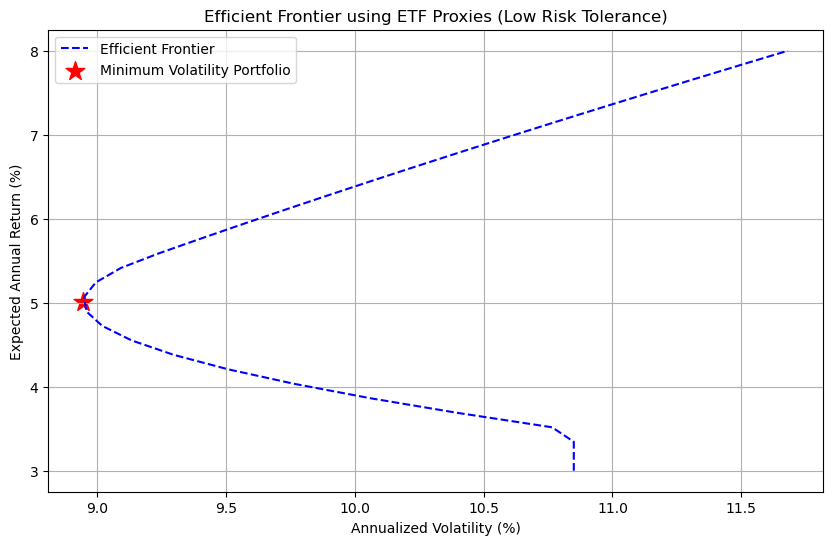

In [292]:
plt.figure(figsize=(10,6))
plt.plot(np.array(frontier_vols)*100, target_returns*100, 'b--', label='Efficient Frontier')
plt.scatter(min_volatility*100, min_ret*100, c='red', marker='*', s=200, label='Minimum Volatility Portfolio')
plt.title("Efficient Frontier using ETF Proxies (Low Risk Tolerance)")
plt.xlabel("Annualized Volatility (%)")
plt.ylabel("Expected Annual Return (%)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
##dfhrp = dfdata.copy()

In [430]:
#hrp = HRPOpt(returns=returns, cov_matrix=cov_matrix)

In [431]:
#hrp.optimize()

OrderedDict([('BNDS', 0.8178609793404243),
             ('COMM', 0.07981785141615139),
             ('STKS', 0.10232116924342431)])

In [432]:
cov_matrix

,BNDS,COMM,STKS
BNDS,0.004665,0.000365,0.002653
COMM,0.000365,0.061985,0.017827
STKS,0.002653,0.017827,0.044089


In [433]:
#weights = hrp.optimize()

In [434]:
linkage_matrix = hrp.clusters

In [435]:
linkage_matrix

array([[0.        , 2.        , 0.45944544, 2.        ],
       [1.        , 3.        , 0.56158288, 3.        ]])

In [387]:
dfdata.head()

,Date,BNDS,COMM,STKS
0,2020-01-02,95.997124,16.290001,298.578705
1,2020-01-03,96.278214,16.510000,296.317749
2,2020-01-06,96.201561,16.510000,297.448181
3,2020-01-07,96.099342,16.459999,296.611816
4,2020-01-08,95.988617,16.150000,298.192719


In [388]:
dfhrp.head()

,Date,BNDS,COMM,STKS
0,2020-01-02,95.997124,16.290001,298.578705
1,2020-01-03,96.278214,16.510000,296.317749
2,2020-01-06,96.201561,16.510000,297.448181
3,2020-01-07,96.099342,16.459999,296.611816
4,2020-01-08,95.988617,16.150000,298.192719


In [389]:
dfhrp.columns

Index(['Date', 'BNDS', 'COMM', 'STKS'], dtype='object')

In [391]:
dfhrp.dtypes

Date    datetime64[ns]
BNDS           float64
COMM           float64
STKS           float64
dtype: object

In [392]:
dfhrp1 = dfhrp.set_index('Date')

In [393]:
dfhrp1.head()

,BNDS,COMM,STKS
Date,,,
2020-01-02,95.997124,16.290001,298.578705
2020-01-03,96.278214,16.510000,296.317749
2020-01-06,96.201561,16.510000,297.448181
2020-01-07,96.099342,16.459999,296.611816
2020-01-08,95.988617,16.150000,298.192719


In [395]:
monthly_prices = dfhrp1.resample("M").last()

In [366]:
dfhrp = dfhrp.drop(['Date'], axis=1)

In [368]:
dfhrp = dfhrp.reset_index(drop=True)

In [396]:
dfhrp.head()

,Date,BNDS,COMM,STKS
0,2020-01-02,95.997124,16.290001,298.578705
1,2020-01-03,96.278214,16.510000,296.317749
2,2020-01-06,96.201561,16.510000,297.448181
3,2020-01-07,96.099342,16.459999,296.611816
4,2020-01-08,95.988617,16.150000,298.192719


In [322]:
dfhrp = dfhrp.reset_index(drop=True)

In [323]:
dfhrp = dfhrp.pct_change().dropna()

In [397]:
dfhrp.head()

,Date,BNDS,COMM,STKS
0,2020-01-02,95.997124,16.290001,298.578705
1,2020-01-03,96.278214,16.510000,296.317749
2,2020-01-06,96.201561,16.510000,297.448181
3,2020-01-07,96.099342,16.459999,296.611816
4,2020-01-08,95.988617,16.150000,298.192719


In [398]:
returns = monthly_prices.pct_change().dropna()

In [399]:
mu = expected_returns.mean_historical_return(monthly_prices, frequency=12)

In [400]:
S = risk_models.sample_cov(monthly_prices, frequency=12)

In [401]:
hrp = HRPOpt(returns=returns)

In [402]:
hrp_weights = hrp.optimize()

In [403]:
print("Expected Annual Returns:")
print(mu.round(4))

Expected Annual Returns:
BNDS   -0.0076
COMM    0.0863
STKS    0.1473
dtype: float64


In [455]:
print("\nCovariance Matrix:")


Covariance Matrix:


In [453]:
cov_matrix=S.round(4)

In [454]:
cov_matrix

,BNDS,COMM,STKS
BNDS,0.0042,-0.0014,0.0069
COMM,-0.0014,0.0587,0.0164
STKS,0.0069,0.0164,0.0336


In [439]:
print("\nHRP Portfolio Weights:")
for t, w in hrp_weights.items():
    print(f"{t}: {w*100:.2f}%")


HRP Portfolio Weights:
BNDS: 81.79%
COMM: 7.98%
STKS: 10.23%


In [440]:
print(hrp_weights)

OrderedDict([('BNDS', 0.8178609793404243), ('COMM', 0.07981785141615139), ('STKS', 0.10232116924342431)])


In [406]:
ret, vol, sharpe = hrp.portfolio_performance(risk_free_rate=0.01)

In [443]:
print(f"\nExpected Annual Return: {ret:.2%}")
print(f"Expected Volatility: {vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")


Expected Annual Return: 42.89%
Expected Volatility: 31.66%
Sharpe Ratio: 1.32


In [450]:
cluster_matrix = hrp.clusters

In [458]:
cluster_matrix

array([[0.        , 2.        , 0.45944544, 2.        ],
       [1.        , 3.        , 0.56158288, 3.        ]])

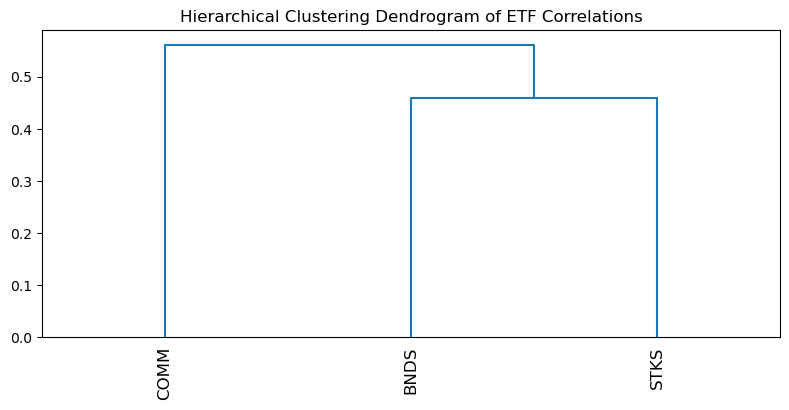

In [466]:
plt.figure(figsize=(8, 4))
plotting.plot_dendrogram(hrp)
plt.title("Hierarchical Clustering Dendrogram of ETF Correlations")
plt.show()